## contrastive

In [1]:
import pickle
with open('con_loaded_data_2000.pickle', 'rb') as f:
    DATA = pickle.load(f) 

In [2]:
len(DATA[1]['MEL'])

29644

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np

import librosa 
import librosa.display
import pylab
import cv2
import os

Using TensorFlow backend.


## grayscale

In [10]:
import random
class CustomDatase_1D(tf.keras.utils.Sequence):
    def __init__(self,imgfiles, batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, x = self.__data_generation(indexes)
        return X, x

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def timeshift(self, img, shift=10, direction='right', roll=True):
        direction_list= ['right', 'left']
        direction = random.choice(direction_list)
        img = img.copy()
        if direction == 'right':
            right_slice = img[:, -shift:].copy()
            img[:, shift:] = img[:, :-shift]
            if roll:
                img[:,:shift] = np.fliplr(right_slice)
        if direction == 'left':
            left_slice = img[:, :shift].copy()
            img[:, :-shift] = img[:, shift:]
            if roll:
                img[:, -shift:] = left_slice
        return img
    
    def block_masking(self, wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
        for _ in range(time_mask_num):
            t = np.random.uniform(low=0.0, high=T)
            t = int(t)
            t0 = random.randint(0, seq_len - t)
            for _ in range(freq_mask_num):
                f = np.random.uniform(low=0.0, high=F)
                f = int(f)
                f0 = random.randint(0, feat_size - f)
                
                wav[t0 : t0 + t, f0 : f0 + f] = 0
        return wav      
    
    def gaussian_noise(self,img, mean=0, sigma=3):
        img = img.copy()
        noise = np.random.normal(mean, sigma, img.shape )
        mask_overflow_upper = img+noise >= 1.0
        mask_overflow_lower = img+noise < 0
        noise[mask_overflow_upper] = 1.0
        noise[mask_overflow_lower] = 0
        img=np.add(img, noise, out=img, casting="unsafe")
#         img += noise
        return img   
    
    def spec_augment(self, wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
          # freq mask
        for _ in range(time_mask_num):
            t = np.random.uniform(low=0.0, high=T)
            t = int(t)
            t0 = random.randint(0, seq_len - t)
            wav[t0 : t0 + t] = 0
        # time mask
        for _ in range(freq_mask_num):
            f = np.random.uniform(low=0.0, high=F)
            f = int(f)
            f0 = random.randint(0, feat_size - f)
            wav[:, f0 : f0 + f] = 0
        return wav
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        x = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            img   = cv2.imread(self.imgfiles[ID])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
            img = np.expand_dims(img, axis=-1)
            img = self.timeshift(img)
            
            img2   = cv2.imread(self.imgfiles[ID])
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            img2   = cv2.resize(img2,self.dim,interpolation = cv2.INTER_CUBIC)
            img2 = np.expand_dims(img2, axis=-1)
            img2 = self.block_masking(img2)
            
            X[i,] = img / self.scale
            x[i,] = img2 / self.scale

        return X, x #keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class specGenerator_1D(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, batch_size,target_size=(64,64)):
        self.genX2 = CustomDatase_1D(X2,batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, X_2_batch = self.genX2.__getitem__(index)
        return X_batch, X_2_batch

## RGB

In [203]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles, batch_size,target_size=(64,64,3),shuffle=False,scale=255,n_classes=1,n_channels=3):
        self.batch_size = batch_size
        self.dim        = target_size
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, x = self.__data_generation(indexes)
        return X, x

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def timeshift(self, img, shift=10, direction='right', roll=True):
        direction_list= ['right', 'left']
        direction = random.choice(direction_list)
        img = img.copy()
        if direction == 'right':
            right_slice = img[:, -shift:].copy()
            img[:, shift:] = img[:, :-shift]
            if roll:
                img[:,:shift] = np.fliplr(right_slice)
        if direction == 'left':
            left_slice = img[:, :shift].copy()
            img[:, :-shift] = img[:, shift:]
            if roll:
                img[:, -shift:] = left_slice
        return img    
            
    def block_masking(self, wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
        for _ in range(time_mask_num):
            t = np.random.uniform(low=0.0, high=T)
            t = int(t)
            t0 = random.randint(0, seq_len - t)
            for _ in range(freq_mask_num):
                f = np.random.uniform(low=0.0, high=F)
                f = int(f)
                f0 = random.randint(0, feat_size - f)
                
                wav[t0 : t0 + t, f0 : f0 + f] = 0
        return wav            
    
    def spec_augment(self, wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
         # freq mask
        for _ in range(time_mask_num):
            t = np.random.uniform(low=0.0, high=T)
            t = int(t)
            t0 = random.randint(0, seq_len - t)
            wav[t0 : t0 + t] = 0
        # time mask
        for _ in range(freq_mask_num):
            f = np.random.uniform(low=0.0, high=F)
            f = int(f)
            f0 = random.randint(0, feat_size - f)
            wav[:, f0 : f0 + f] = 0
        return wav

    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        x = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img = np.expand_dims(img, axis=-1)
            img = self.timeshift(img)
            
            img2   = cv2.imread(self.imgfiles[ID])
#             img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            img2   = cv2.resize(img2,self.dim,interpolation = cv2.INTER_CUBIC)
#             img2 = np.expand_dims(img2, axis=-1)
            img2 = self.block_masking(img2)
            
            X[i,] = img / self.scale
            x[i,] = img2 / self.scale

            self.c +=1
        return X, x #keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class specGenerator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, batch_size,target_size=(64,64)):
        self.genX2 = CustomDataset(X2,batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, X_2_batch = self.genX2.__getitem__(index)
        return X_batch, X_2_batch

## 2d grayscale

In [5]:
def build_model_1D():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64,1))
    lay1_  = Conv2D(64, (3, 3), strides=(2, 2))(inp2)
    lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv2D(128, (3, 3), padding="same") (lay4_)
    lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv2D(128, (3, 3), padding="same") (lay8_)
    lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.5)(lay14_)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    # projection head
    x = tf.keras.layers.Dense(256)(lay13_)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)
    MERGM   = Model(inputs=inp2, outputs=lay15_)

    return MERGM

## 2D RGB

In [201]:
def build_model():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64,3))
    lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
    lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
    lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
    lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.3)(lay14_)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    # projection head
    x = tf.keras.layers.Dense(256)(lay13_)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)
    MERGM   = Model(inputs=inp2, outputs=lay15_)

    return MERGM

In [6]:
def ResNetSimCLR(base_model='resnet18'):
    inputs = tf.keras.layers.Input(shape=(64,64,1))

    
    
    
    base_encoder = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None,
                                                  input_shape=(64,64,1), pooling='avg')
    base_encoder.training = True
    
    h = base_encoder(inputs)

    # projection head
    x = tf.keras.layers.Dense(256)(h)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [7]:
def EfficientSimCLR(base_model='efficient'):
    inputs = tf.keras.layers.Input(shape=(64,64,1))

    base_encoder = tf.keras.applications.EfficientNetB0(include_top=False, weights=None, input_tensor=None,
                                                        input_shape=(64,64,1), pooling='avg')
    base_encoder.training = True
    h = base_encoder(inputs)

    # projection head
    x = tf.keras.layers.Dense(256)(h)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [8]:
import tensorflow.keras.backend as K
cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def _dot_simililarity_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def _dot_simililarity_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v



def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

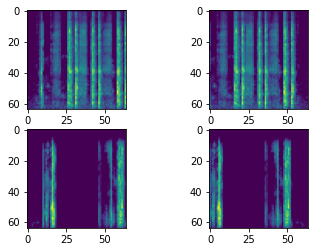

loss tf.Tensor(7.8305564, shape=(), dtype=float32)


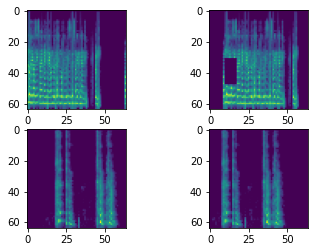

loss tf.Tensor(7.745997, shape=(), dtype=float32)


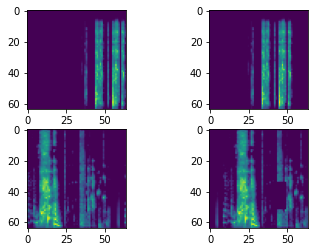

loss tf.Tensor(7.711371, shape=(), dtype=float32)


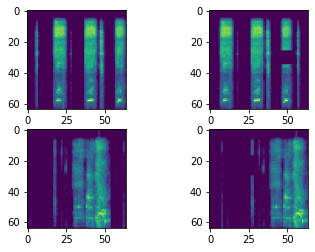

loss tf.Tensor(7.688611, shape=(), dtype=float32)


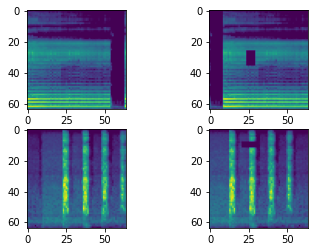

loss tf.Tensor(7.676389, shape=(), dtype=float32)


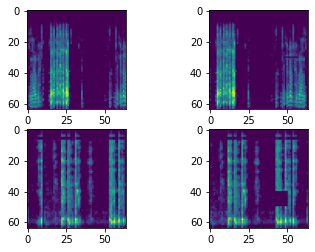

loss tf.Tensor(7.6633945, shape=(), dtype=float32)


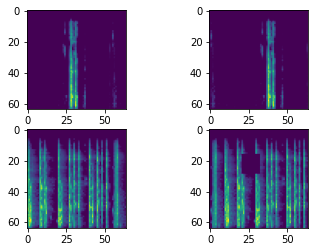

loss tf.Tensor(7.6518774, shape=(), dtype=float32)


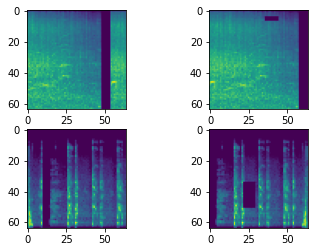

loss tf.Tensor(7.643262, shape=(), dtype=float32)


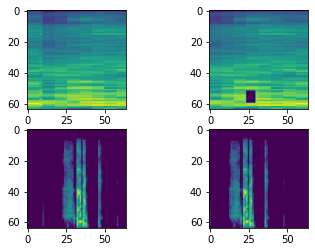

loss tf.Tensor(7.6378994, shape=(), dtype=float32)


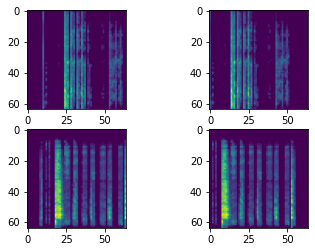

loss tf.Tensor(7.6356993, shape=(), dtype=float32)


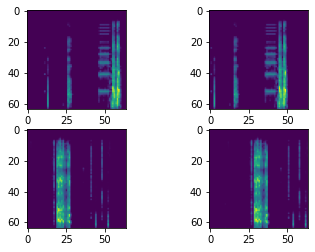

loss tf.Tensor(7.631931, shape=(), dtype=float32)


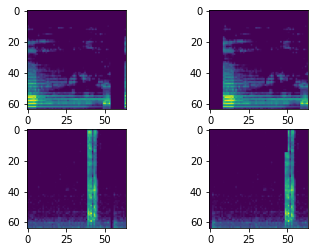

loss tf.Tensor(7.6299815, shape=(), dtype=float32)


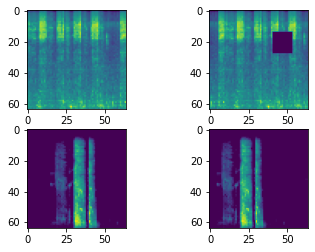

loss tf.Tensor(7.627278, shape=(), dtype=float32)


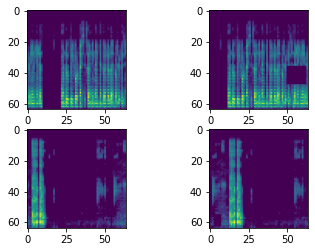

loss tf.Tensor(7.6261806, shape=(), dtype=float32)


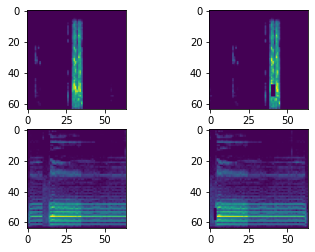

loss tf.Tensor(7.62543, shape=(), dtype=float32)


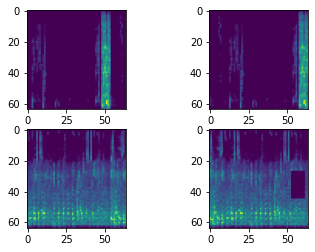

loss tf.Tensor(7.623563, shape=(), dtype=float32)


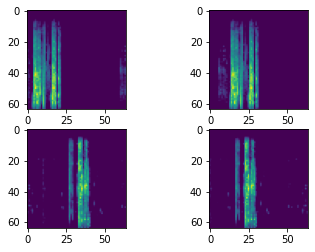

loss tf.Tensor(7.6234, shape=(), dtype=float32)


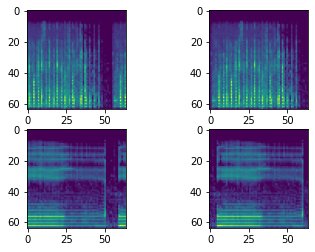

loss tf.Tensor(7.6195636, shape=(), dtype=float32)


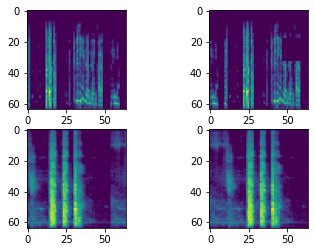

loss tf.Tensor(7.6202025, shape=(), dtype=float32)


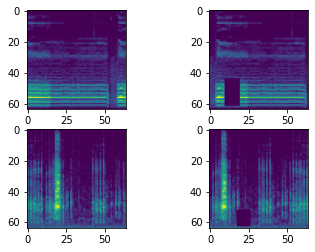

loss tf.Tensor(7.6186714, shape=(), dtype=float32)


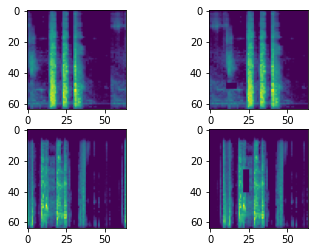

loss tf.Tensor(7.617075, shape=(), dtype=float32)


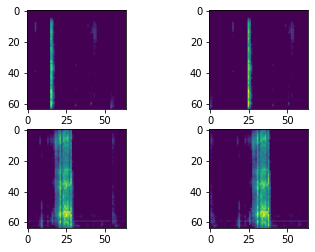

loss tf.Tensor(7.614627, shape=(), dtype=float32)


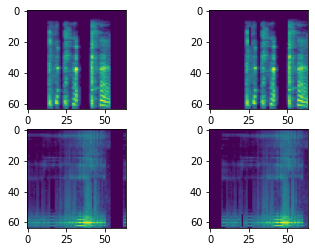

loss tf.Tensor(7.6139164, shape=(), dtype=float32)


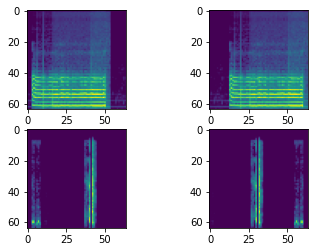

loss tf.Tensor(7.61137, shape=(), dtype=float32)


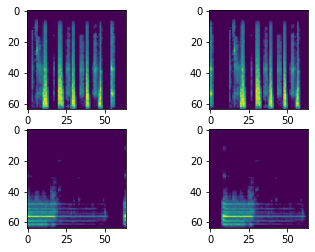

loss tf.Tensor(7.6080556, shape=(), dtype=float32)


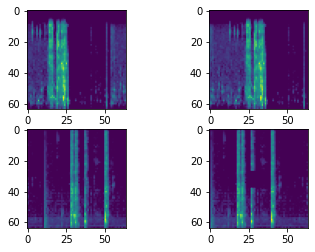

loss tf.Tensor(7.6052346, shape=(), dtype=float32)


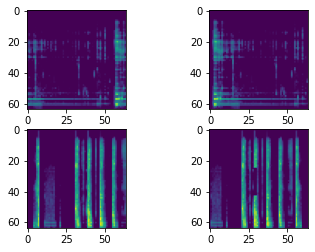

loss tf.Tensor(7.6028714, shape=(), dtype=float32)


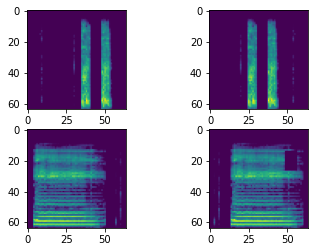

loss tf.Tensor(7.5971813, shape=(), dtype=float32)


In [11]:
# Create directory to save models
import tensorflow as tf
import datetime
import os
import yaml
import time
import shutil
import random
import matplotlib.pyplot as plt

NUM_shuf= 1

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    MERGM = build_model_1D()
    
    #data_size = len(DATA[RUN]['MEL'])
    
    timgs     = DATA[RUN]['MEL']
    #[:int(0.168*data_size)]
    imgs_em  = specGenerator_1D(timgs,batch_size=1028,target_size=(64,64))
    
    negative_mask = get_negative_mask(1028)
    
    train_log_dir = os.path.join('./contrastive/cosine', 'train')
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    optimizer = tf.keras.optimizers.Adam(0.0001)


    def train_step(xis, xjs):
        with tf.GradientTape() as tape:

            zis = MERGM(xis)
            zjs = MERGM(xjs)

            # normalize projection feature vectors
            zis = tf.math.l2_normalize(zis, axis=1)
            zjs = tf.math.l2_normalize(zjs, axis=1)

            # tf.summary.histogram('zis', zis, step=optimizer.iterations)
            # tf.summary.histogram('zjs', zjs, step=optimizer.iterations)

            l_pos = _cosine_simililarity_dim1(zis, zjs)
            l_pos = tf.reshape(l_pos, (1028, 1))
            l_pos /= 0.5
#             assert l_pos.shape == (48, 1), "l_pos shape not valid" + str(l_pos.shape)  # [N,1]

            negatives = tf.concat([zjs, zis], axis=0)

            loss = 0

            for positives in [zis, zjs]:
                l_neg = _cosine_simililarity_dim2(positives, negatives)

                labels = tf.zeros(1028, dtype=tf.int32)

                l_neg = tf.boolean_mask(l_neg, negative_mask)
                l_neg = tf.reshape(l_neg, (1028, -1))
                l_neg /= 0.5

#                 assert l_neg.shape == (
#                     48, 2 * (48 - 1)), "Shape of negatives not expected." + str(
#                     l_neg.shape)
                logits = tf.concat([l_pos, l_neg], axis=1)  # [N,K+1]
                loss += criterion(y_pred=logits, y_true=labels)

            loss = loss / (2 * 1028)
            tf.summary.scalar('loss', loss, step=optimizer.iterations)
            print('loss',loss)

        gradients = tape.gradient(loss, MERGM.trainable_variables)
        optimizer.apply_gradients(zip(gradients, MERGM.trainable_variables))


    with train_summary_writer.as_default():
        for xis, xjs in imgs_em:
#             print(tf.reduce_min(xis), tf.reduce_max(xjs))
            fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=False)
            axs[0, 0].imshow(xis[1])
            axs[0, 1].imshow(xjs[1])

            axs[1, 0].imshow(xis[8])
            axs[1, 1].imshow(xjs[8])
            plt.show()
#             start = time.time()
            train_step(xis, xjs)
#             end = time.time()
#             print("Total time per batch:", end - start)

    model_checkpoints_folder = os.path.join(train_log_dir, 'checkpoints')
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
    a = 'model'+ str(RUN+1) + '.h5'    
    MERGM.save(os.path.join(model_checkpoints_folder, a))

## downstream

In [15]:
import pickle
with open('sup_loaded_data_2000.pickle', 'rb') as f:
    sup_DATA = pickle.load(f) 

In [16]:
class sup_CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    min_level_db= -100        
    def normalize_mel(self,S):
        return np.clip((S-min_level_db)/-min_level_db,0,1)


    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img   = self.normalize_mel(img)
            img = np.expand_dims(img, axis=-1)
            X[i,] = img / self.scale

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class sup_specGenerator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, Y, batch_size,target_size=(64,64)):
        self.genX2 = sup_CustomDataset(X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, Y_batch = self.genX2.__getitem__(index)
        return X_batch, Y_batch

In [17]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

class Evaluation(Callback):
    def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
        super(Evaluation, self).__init__()
        self.test_data = test_data_gen
        self.val_labels = val_labels
        self.val_data = val_data_gen
        self.test_labels = test_labels

    def on_epoch_end(self, epoch, logs=None):
        y_preds = self.model.predict_generator(self.val_data)
        print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

        y_preds = self.model.predict_generator(self.test_data)
        print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [18]:
def down_build_model():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

#     # Second Model
#     inp2   = Input(shape=(64,64,3))
#     lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
#     lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
#     lay3_  = BatchNormalization()(lay2_)
#     lay4_  = Activation('relu')(lay3_)

#     lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
#     lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
#     lay7_  = BatchNormalization()(lay6_)
#     lay8_  = Activation('relu')(lay7_)

#     lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
#     lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
#     lay11_ = BatchNormalization()(lay10_)
#     lay12_ = Activation('relu')(lay11_)

#     lay13_ = Flatten()(lay12_)
#     lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
#     lay15_ = Dropout(rate=0.5)(lay14_)

    inp2   = Input(shape=(64,64,1))
    base_encoder = keras.models.load_model("./contrastive/cosine/train/checkpoints/model1.h5")
    base_encoder.trainable = False
    
    h = base_encoder(inp2,training=False)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(h)
    output  = Dense(1, activation='sigmoid')(lay14_)
    sup_MERGM   = Model(inputs=inp2, outputs=output)

    return sup_MERGM

In [19]:
# Create directory to save models
rt_sv_dir = './downstream/downstream_cosin'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)
NUM_shuf= 5

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    with tf.device("/gpu:0"):    
        sup_MERGM = down_build_model()

        Adam = tf.keras.optimizers.Adam(0.001)
                                        

        sup_MERGM.compile(
          optimizer = Adam,
          loss = 'BinaryCrossentropy',
            metrics=['AUC'])

        sup_data_size = len(sup_DATA[RUN]['MEL'])

        sup_timgs     = sup_DATA[RUN]['MEL'][:int(0.7*sup_data_size)]
        sup_labels    = sup_DATA[RUN]['LABELS'][:int(0.7*sup_data_size)]

        sup_test_imgs    = sup_DATA[RUN]['MEL'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
        sup_test_labels  = sup_DATA[RUN]['LABELS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]

        
        sup_val_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
        sup_val_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]

        sup_imgs_em      = sup_specGenerator(sup_timgs,sup_labels,batch_size=32,target_size=(64,64))
        TEST          = sup_specGenerator(sup_test_imgs,sup_test_labels,batch_size=32,target_size=(64,64))
        VAL         = sup_specGenerator(sup_val_imgs,sup_val_labels,batch_size=32,target_size=(64,64))
        tf.random.set_seed(6)


        evaluator = Evaluation(VAL, sup_val_labels, TEST, sup_test_labels)
        checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                    "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
        os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
        history = sup_MERGM.fit_generator(
                      sup_imgs_em,
                      epochs=30,
                      validation_data=VAL, 
                      verbose=2, 
                      callbacks=[evaluator, checkpointer])
        historys[RUN]=history.history
        

        sup_MERGM_Record1 = sup_MERGM.evaluate_generator(
        TEST
        )

        print()
        print('Results: Loss = {} , AUC = {} '.format(sup_MERGM_Record1[0],sup_MERGM_Record1[1]))

        print()
        from sklearn.metrics import roc_auc_score


        y_val  = sup_val_labels
        y_preds_val = sup_MERGM.predict_generator(VAL)
        print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))
        
        y_test  = sup_test_labels
        y_preds_test = sup_MERGM.predict(TEST)
        print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
        print()
        print('-----------------------------------------------------------------')

rm: cannot remove './downstream/downstream_cosin': No such file or directory
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
Instructions for updating:
Please use Model.predict, which supports generators.
 | val_auc: 0.7845982142857143
 | test_auc: 0.8063081176174918
43/43 - 6s - loss: 0.6832 - auc: 0.5086 - val_loss: 0.6708 - val_auc: 0.7065
Epoch 2/30
 | val_auc: 0.7001318993506493
 | test_auc: 0.7137220407137471
43/43 - 6s - loss: 0.6688 - auc: 0.6298 - val_loss: 0.6558 - val_auc: 0.6971
Epoch 3/30
 | val_auc: 0.691507711038961
 | test_auc: 0.7036692636340789
43/43 - 6s - loss: 0.6494 - auc: 0.6904 - val_loss: 0.6386 - val_auc: 0.6917
Epoch 4/30
 | val_auc: 0.7099228896103895
 | test_auc: 0.7278964563960795
43/43 - 6s - loss: 0.6315 - auc: 0.6984 - val_loss: 0.6202 - val_auc: 0.7077
Epoch 5/30
 | val_auc: 0.7098214285714286
 | test_auc: 0.725785373209349
43/43 - 6s - loss: 0.6174 - auc: 0.7031 - val_loss: 0.6075 - val_auc: 0.7100
Epoch 6/30
 | 

Epoch 17/30
 | val_auc: 0.871577380952381
 | test_auc: 0.8140997513529327
43/43 - 6s - loss: 0.5352 - auc: 0.7950 - val_loss: 0.5047 - val_auc: 0.8715
Epoch 18/30
 | val_auc: 0.8743551587301588
 | test_auc: 0.8174637999122423
43/43 - 6s - loss: 0.5277 - auc: 0.8099 - val_loss: 0.4955 - val_auc: 0.8746
Epoch 19/30
 | val_auc: 0.8769345238095237
 | test_auc: 0.82141290039491
43/43 - 6s - loss: 0.5198 - auc: 0.8185 - val_loss: 0.4891 - val_auc: 0.8772
Epoch 20/30
 | val_auc: 0.8806051587301588
 | test_auc: 0.8259470528009362
43/43 - 6s - loss: 0.5135 - auc: 0.8240 - val_loss: 0.4840 - val_auc: 0.8805
Epoch 21/30
 | val_auc: 0.8845238095238095
 | test_auc: 0.8313587830919995
43/43 - 6s - loss: 0.5105 - auc: 0.8245 - val_loss: 0.4804 - val_auc: 0.8848
Epoch 22/30
 | val_auc: 0.8879464285714287
 | test_auc: 0.8352591292477208
43/43 - 6s - loss: 0.5025 - auc: 0.8320 - val_loss: 0.4775 - val_auc: 0.8879
Epoch 23/30
 | val_auc: 0.8901785714285714
 | test_auc: 0.8385256691531373
43/43 - 6s - los

 | test_auc: 0.7818330281585589
43/43 - 6s - loss: 0.6031 - auc: 0.7088 - val_loss: 0.6523 - val_auc: 0.7083
Epoch 8/30
 | val_auc: 0.7106676521310668
 | test_auc: 0.7831691987924977
43/43 - 6s - loss: 0.5962 - auc: 0.7166 - val_loss: 0.6311 - val_auc: 0.7107
Epoch 9/30
 | val_auc: 0.720670115792067
 | test_auc: 0.7920275152174988
43/43 - 6s - loss: 0.5917 - auc: 0.7259 - val_loss: 0.6378 - val_auc: 0.7197
Epoch 10/30
 | val_auc: 0.7229366839122936
 | test_auc: 0.7949967832929183
43/43 - 6s - loss: 0.5855 - auc: 0.7308 - val_loss: 0.6190 - val_auc: 0.7220
Epoch 11/30
 | val_auc: 0.7249568859324956
 | test_auc: 0.796877319740684
43/43 - 6s - loss: 0.5809 - auc: 0.7361 - val_loss: 0.6039 - val_auc: 0.7252
Epoch 12/30
 | val_auc: 0.7284060113328406
 | test_auc: 0.7999950512198744
43/43 - 6s - loss: 0.5748 - auc: 0.7455 - val_loss: 0.5955 - val_auc: 0.7283
Epoch 13/30
 | val_auc: 0.7328406011332839
 | test_auc: 0.8035086851091205
43/43 - 6s - loss: 0.5657 - auc: 0.7608 - val_loss: 0.5910 -

Epoch 30/30
 | val_auc: 0.8713820901320902
 | test_auc: 0.8771205986366665
43/43 - 6s - loss: 0.4664 - auc: 0.8581 - val_loss: 0.4636 - val_auc: 0.8716

Results: Loss = 0.45674508810043335 , AUC = 0.8768643140792847 

val: 0.8713820901320902
test 0.8771205986366665

-----------------------------------------------------------------


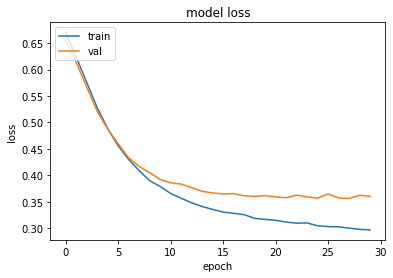

In [53]:

import matplotlib.pyplot as plt
plt.plot(historys[3]['loss'])
plt.plot(historys[3]['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() 

In [54]:
historys[3]['loss']

[0.6705177426338196,
 0.6237131953239441,
 0.5759893655776978,
 0.5280385613441467,
 0.4884538948535919,
 0.4559016525745392,
 0.4300229251384735,
 0.4089626371860504,
 0.3900136649608612,
 0.37895020842552185,
 0.36581912636756897,
 0.3566613793373108,
 0.3481498658657074,
 0.34107455611228943,
 0.33554401993751526,
 0.3305665850639343,
 0.3281691074371338,
 0.32566213607788086,
 0.3187542259693146,
 0.3167007267475128,
 0.3150230348110199,
 0.31168389320373535,
 0.30952295660972595,
 0.3100535571575165,
 0.3046813905239105,
 0.30309242010116577,
 0.3027110695838928,
 0.30023205280303955,
 0.29781392216682434,
 0.29680776596069336]

In [55]:
historys[3]['val_loss']

[0.6559712886810303,
 0.6135051250457764,
 0.5671822428703308,
 0.5210575461387634,
 0.48742735385894775,
 0.4598797559738159,
 0.4330938458442688,
 0.41702502965927124,
 0.40491777658462524,
 0.3923276662826538,
 0.38589414954185486,
 0.3834691047668457,
 0.3768264949321747,
 0.3698281943798065,
 0.3667724132537842,
 0.3648911118507385,
 0.365409791469574,
 0.3613690137863159,
 0.3602175712585449,
 0.36175739765167236,
 0.3591752052307129,
 0.3576661944389343,
 0.36258193850517273,
 0.3593119978904724,
 0.3567081093788147,
 0.36512693762779236,
 0.3572503924369812,
 0.3563021123409271,
 0.3622395694255829,
 0.36043038964271545]

0
Num_samples: 288
acc:  0.8993055555555556
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 288
acc:  0.8993055555555556
2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 288
acc:  0.8993055555555556


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


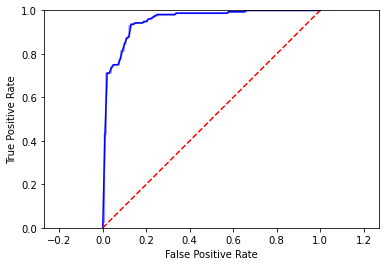

In [198]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: './model_1/0/*.hdf5',
          1: './model_1/1/*.hdf5',
          2: './model_1/2/*.hdf5',
          3: './model_1/3/*.hdf5',
          4: './model_1/4/*.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(3):
    print(iii)
    test_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
    test_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]
    TEST          = sup_specGenerator(test_imgs,test_labels,batch_size=48,target_size=(64,64))
#     for file in os.listdir(path):
#         model_path = path+'/'+file
#         model_path = path+'/'+file
    model = keras.models.load_model("./downstream/downstream_2000_1D_time_spec/4/018--0.276--0.306.hdf5")
    y_score = model.predict(TEST)
    fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
    
    print('Num_samples:', len(y_score))
    print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()